# "Neo4j in handling IMDB dataset"
> "Querying a database using NoSQL graph approach"

- toc: true
- comments: true
- image: images/neo4j.gif
- categories: [project]
- tags: [Neo4j, NoSQL, Visualization]
- badges: true
- twitter_large_image: true
- featured: false

## <span style='background:lightblue'> Data Loading Codes </span>

:auto using periodic commit

load csv with headers from "file:///actors.csv" as row fieldterminator ";"

with row, (case row.sex when "M" then "Male" when "F" then "Female" else "Other" end) as sex, split(row.name, ",") as name

create (a:Actor)

set a.actorId = toInteger(row.actorid), a.name = (ltrim(name[1])+ " " + name[0]), a.sex = sex

----------------------------------------------

**1- Create Constraint on Movies Ids:**

create constraint on (m:Movie) ASSERT m.movieId is unique

----------------------------------------------

**2- Load Movies**

:auto using periodic commit

load csv with headers from "file:///movies.csv" as row fieldterminator ";"

create (m:Movie)

set m.movieId = toInteger(row.movieid), m.title = trim(split(row.title, "(")[0]), m.year = toInteger(row.year)

----------------------------------------------

**3- Load Directors:**

:auto using periodic commit

load csv with headers from "file:///directors.csv" as row fieldterminator ";"

create (d:Director)

set d.directorId = toInteger(row.directorid), d.name = row.name

----------------------------------------------

**4- Load Actors:**

:auto using periodic commit

load csv with headers from "file:///actors.csv" as row fieldterminator ";"

with row, (case row.sex when "M" then "Male" when "F" then "Female" else "Other" end) as sex

create (a:Actor)

set a.actorId = toInteger(row.actorid), a.name = row.name, a.sex = sex

----------------------------------------------

**5- Load Writers:**

:auto using periodic commit 500

load csv with headers from "file:///writers.csv" as row fieldterminator ";"

create (w:Writer)

set w.writerId = toInteger(row.writerid), w.name = row.name

----------------------------------------------

**6- Create WRITTEN_BY:**

:auto using periodic commit 500

load csv with headers from "file:///moviestowriters.csv" as row fieldterminator ";"

match (m:Movie {movieId: toInteger(row.movieid)})

match (w:Writer {writerId: toInteger(row.writerid)})

create (m)-[:WRITTEN_BY]->(w)

----------------------------------------------

**7- Create DIRECTED_BY:**

:auto using periodic commit 500

load csv with headers from "file:///moviestodirectors.csv" as row fieldterminator ";"

match (d:Director {directorId : toInteger(row.directorid)})

match (m:Movie {movieId : toInteger(row.movieid)})

create (d)<-[:DIRECTED_BY]-(m)

----------------------------------------------

**8- Create ACTED_IN:**

:auto using periodic commit 500

load csv with headers from "file:///moviestoactors.csv" as row fieldterminator ";"

match (m:Movie {movieId : toInteger(row.movieid)})

match (a:Actor {actorId : toInteger(row.actorid)})

create (a)-[:ACTED_IN]->(m)

----------------------------------------------

**9- Set genre property of Movies:**

:auto using periodic commit 

load csv with headers from "file:///moviestodirectors.csv" as row fieldterminator ";"

match (m:Movie {movieId : toInteger(row.movieid)})

set m.genre = row.genre

----------------------------------------------

**10- Set rank & votes properties of movies:**

:auto using periodic commit 

load csv with headers from "file:///ratings.csv" as row fieldterminator ";"

match (m:Movie {movieId : toInteger(row.movieid)})

set m.rank = toFLoat(row.rank), m.votes= toInteger(row.votes)

----------------------------------------------

**11- Set time property of Movies as duration:**

:auto using periodic commit 

load csv with headers from "file:///runningtimes.csv" as row fieldterminator ";"

match (m:Movie {movieId : toInteger(row.movieid)})

set m.time = duration({minutes: toInteger(row.time1)})

### <span style='background:orange'> Graph Structure </span>

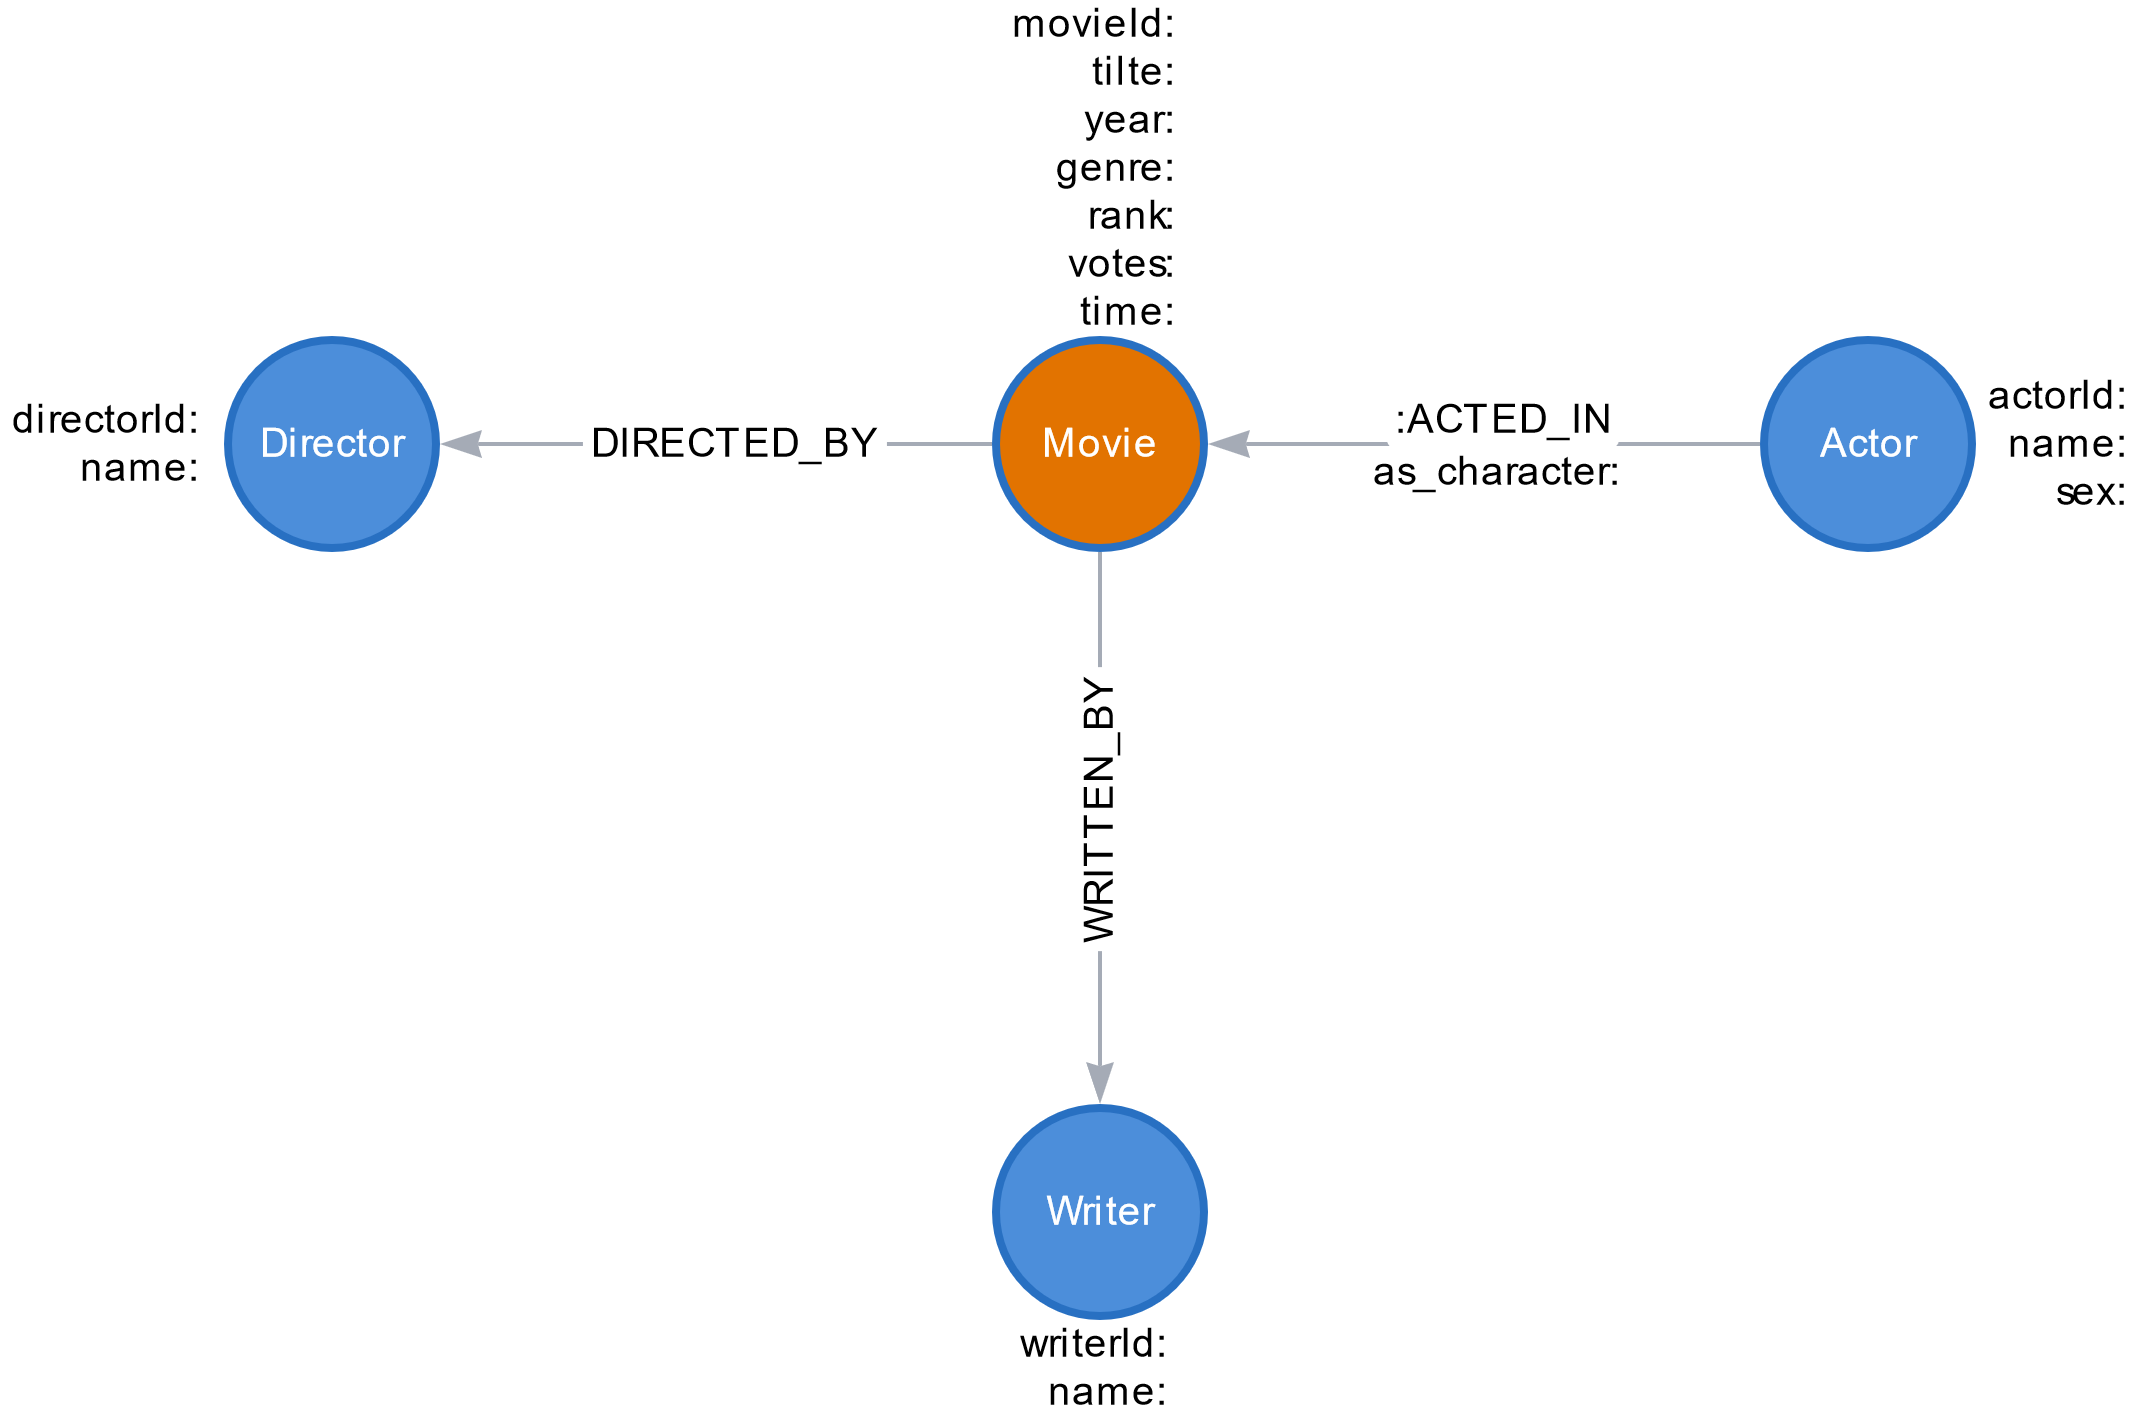

-----
----
-----
----
-----

## <span style='background:lightblue'> Data Excution Codes </span>

**1- How many of movies have been directed by Ron Howard ?**

match (m:Movie)-[:DIRECTED_BY]->(d:Director)

where d.name contains "Howard" and d.name contains "Ron"

return count(m.title) 

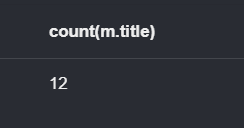

---
---
**2-  Write a single query that shows both the number of female actors and the 
number of male actors in the dataset:**

match (a:Actor)

where a.sex = "Female"

with count(a) as female

match (b:Actor)

where b.sex = "Male"

with count(b) as male, female

return male, female
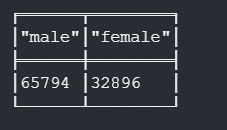

---
---
**3- What is the year of the oldest movie listed in the database?**

match (m:Movie)

return m.year order by m.year limit 1
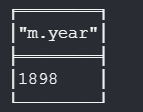

---
---
**4-  List the movie titles and number of directors involved for movies with more 
than 5 directors:**

match (m:Movie)-[:DIRECTED_BY]->(d:Director)

with m, count(d) as dircount

where dircount > 5 

return m.title, dircount
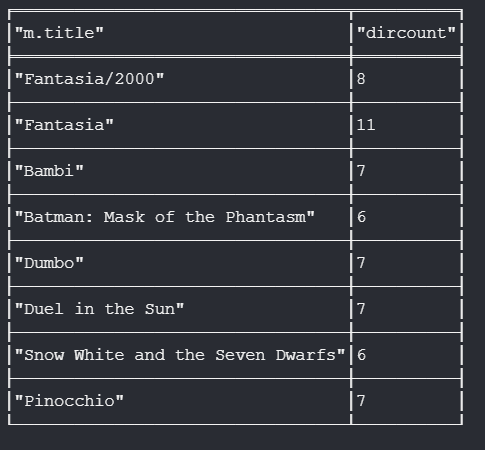

---
---
**5-   Number of movies with a running time of between 15m 00sec to 20mins 
00 seconds (inclusive)  Note: Count all versions of a movie, not just the 
originals; use the time1 column for movie lengths:**

match (m:Movie)

where m.time.minutes >= 15 AND m.time.minutes <= 20

return count(m)
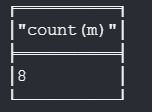

---
---
**6-  Give the movie titles which star both Bill Nighy and Ewan McGregor 
(i.e. both actors were in the same film)**

match (b:Actor)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(a:Actor)

where a.name contains "Bill" and a.name contains "Nighy" and b.name contains "Ewan" and b.name contains "McGregor"

return m.title
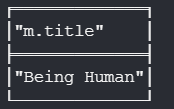

---
---
**7-  How many movies have fewer male actors than female actors?**

match (a:Actor)-[:ACTED_IN]->(m:Movie)

where a.sex = "Female"

with count(a) as females, m

match (b:Actor)-[:ACTED_IN]->(m)

where b.sex = "Male"

with count(b) as males,females, m

where males < females 

return count(m) as Count_of_Movies
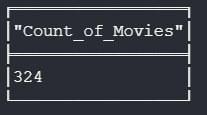

---
---
**8-  List the actors (male/female) that have worked together on more than 10 
films, include their names and number of films they’ve co-starred in:**

match (a:Actor)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(b:Actor)

with a, b, count(m) as moviecount

where moviecount > 10 and a.actorId < b.actorId

return a.name, b.name, moviecount
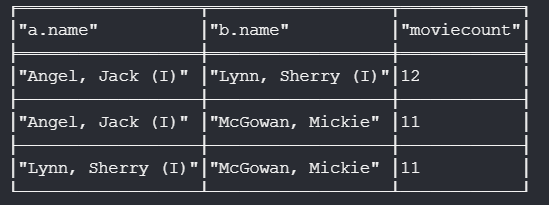

---
---
**9-  List the number of movies released per decade in this dataset, as listed 
below: 
               (1970-79, 1980-89,1990-99,2000-2009, 2010-2019) :**

match (m:Movie)

where 1970<=m.year<1980

with count(m) as `1970-1979`

match (m:Movie)

where 1980<=m.year<1990

with count(m) as `1980-1989`, `1970-1979`

match (m:Movie)

where 1990<=m.year<2000

with count(m) as `1990-1999`, `1970-1979`,`1980-1989`

match (m:Movie)

where 2000<=m.year<2010

with count(m) as `2000-2009`, `1970-1979`,`1980-1989`,`1990-1999`

match (m:Movie)

where 2010<=m.year<2020

with count(m) as `2010-2019`, `1970-1979`,`1980-1989`,`1990-1999`,`2000-2009`

return `1970-1979`, `1980-1989`,`1990-1999`,`2000-2009`,`2010-2019`
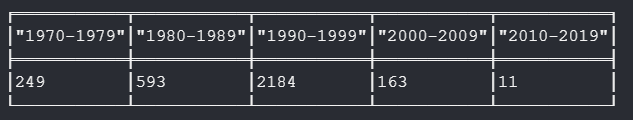

---
---
**10- How many movies did Tom Hanks act in in 1993?**

match (a:Actor)-[:ACTED_IN]->(m:Movie)

where  a.name contains "Tom" and a.name contains "Hanks" and m.year = 1993

return count(m)
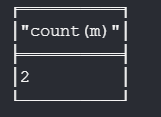

---
---
**11- Based on the average rank per movie genre, which are the top 4 highest 
scoring genres which have received 15,000 or more votes **

match (m:Movie)-[r:DIRECTED_BY]->()

where m.votes > 15000

return r.genre as Genre, avg(m.rank) as Average_Rank order by Average_Rank desc limit 4
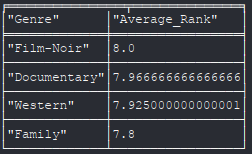

---
---
**12- Show the shortest path between the actor ‘Leonard Nimoy’ and the 1985 
‘Back to the Future’ movie. Include nodes and edges – answer can be shown 
as an image or text description in form (a)-[ ]->(b)-[ ]-> (c)…**


match p=shortestPath((a:Actor)-[*]-(m:Movie))

where a.name contains "Leonard" and a.name contains "Nimoy" and  m.title = "Back to the Future"

return p
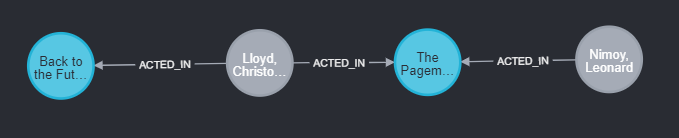

---
---
**13- List all actors (male/female) that have starred in 9 or more different film 
genres  (show names, and number of genres):**

match (a:Actor)-[:ACTED_IN]->(m:Movie)

with a, count(distinct m.genre) as genrecount

where genrecount>=9

return a.name, genrecount
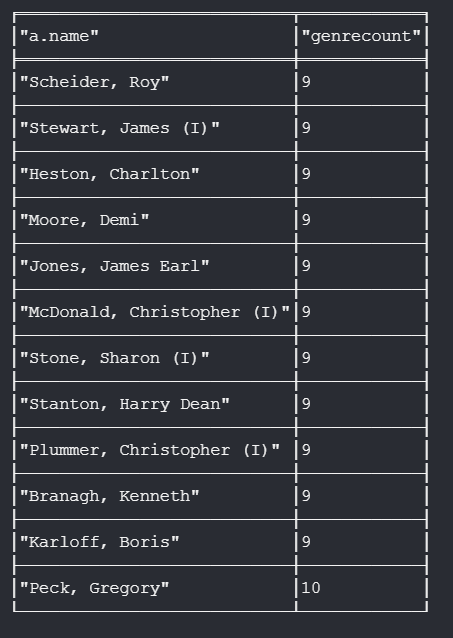

---
---
**14-  How many movies have a female actor that also directed and wrote the 
movie?**

match (a:Actor)-[:ACTED_IN]->(m:Movie), (w:Writer)<-[:WRITTEN_BY]-(m),(d:Director)<-[:DIRECTED_BY]-(m)

where a.sex = "Female" and a.name = w.name = d.name

return count(distinct m)
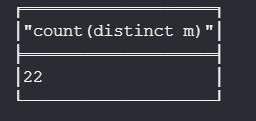

---
---
**15-  How many movies have been written and directed by an actor (male or 
female) that they didn’t star in?  
(i.e. the person who wrote and directed the movie is a film star but didn’t 
appear in the movie) :**

match (a:Actor)

with a

match (w:Writer)<-[:WRITTEN_BY]-(m:Movie)-[:DIRECTED_BY]->(d:Director)

where a.name = w.name = d.name and not (a)-[:ACTED_IN]->(m)

with  distinct w.name as writers, d.name as directors, m.title as movies

return count(movies)
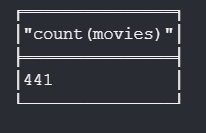